# Constant Solar Flux and Geomagnetic Index Atmospheric Density Model

In this notebook, we will show how to perform orbit propagation using a constant flux and constant geomagnetic index input data for the NRLMSISE-00 atmospheric density model

In [1]:
import plotly.express as px
import pandas as pd
import numpy as np

from ostk.core.filesystem import Directory

from ostk.mathematics.geometry.d3.objects import Cuboid
from ostk.mathematics.geometry.d3.objects import Composite
from ostk.mathematics.geometry.d3.objects import Point

from ostk.physics import Environment
from ostk.physics.coordinate import Frame
from ostk.physics.environment.atmospheric import Earth as EarthAtmosphericModel
from ostk.physics.environment.gravitational import Earth as EarthGravitationalModel
from ostk.physics.environment.magnetic import Earth as EarthMagneticModel
from ostk.physics.environment.objects.celestial_bodies import Earth
from ostk.physics.time import DateTime
from ostk.physics.time import Duration
from ostk.physics.time import Instant
from ostk.physics.time import Scale
from ostk.physics.time import Time
from ostk.physics.time import Interval
from ostk.physics.units import Length
from ostk.physics.units import Mass

from ostk.astrodynamics import Dynamics
from ostk.astrodynamics.trajectory import StateBuilder
from ostk.astrodynamics.trajectory.state import NumericalSolver
from ostk.astrodynamics.trajectory.state import CoordinatesSubset
from ostk.astrodynamics.trajectory.state.coordinates_subset import CartesianPosition
from ostk.astrodynamics.trajectory.state.coordinates_subset import CartesianVelocity
from ostk.astrodynamics.trajectory.orbit.models.kepler import COE
from ostk.astrodynamics.trajectory import Propagator
from ostk.astrodynamics.trajectory import Orbit
from ostk.astrodynamics.flight.system import SatelliteSystem

## User inputs

Setup environment, specifically here we can set-up `NRLMSISE00` to use constant values input instead of leveraging `CSSISpaceWeatherFile` (default) and provide the constant values to be used for:

`f10.7` (SFU)  

`f10.7a` (SFU averaged)  

`Kp` (geomagnetic index)  


If these values are not specified, the default will be `150.0, 150.0, 3.0` respectively.

In [2]:
earth = Earth.from_models(
    EarthGravitationalModel(
        EarthGravitationalModel.Type.EGM96, Directory.undefined(), 20, 20
    ),
    EarthMagneticModel(EarthMagneticModel.Type.Undefined),
    EarthAtmosphericModel(
        type=EarthAtmosphericModel.Type.NRLMSISE00,
        input_data_type=EarthAtmosphericModel.InputDataType.ConstantFluxAndGeoMag,
        f107_constant_value=160.0,
        f107_average_constant_value=160.0,
        kp_constant_value=3.0,
    ),
)

In [3]:
environment = Environment(Instant.J2000(), [earth])

Initial state

In [4]:
instant = Instant.date_time(DateTime(2023, 1, 1), Scale.UTC)
initial_state = Orbit.sun_synchronous(
    instant, Length.kilometers(505.0), Time.midnight(), Earth.default()
).get_state_at(instant)

In [5]:
dry_mass = Mass.kilograms(100.0)

## Setup Dynamics, initial state and Satellite System

In [6]:
satellite_geometry = Composite(
    Cuboid(Point(0.0, 0.0, 0.0), np.eye(3).tolist(), [1.0, 0.0, 0.0])
)

satellite_system = SatelliteSystem(dry_mass, satellite_geometry, np.eye(3), 500.0, 2.2)

In [7]:
state_builder = StateBuilder(
    frame=Frame.GCRF(),
    coordinates_subsets=[
        CartesianPosition.default(),
        CartesianVelocity.default(),
        CoordinatesSubset.mass(),
        CoordinatesSubset.surface_area(),
        CoordinatesSubset.drag_coefficient(),
    ],
)

coordinates = [
    *initial_state.get_coordinates().tolist(),
    dry_mass.in_kilograms(),
    satellite_system.get_cross_sectional_surface_area(),
    satellite_system.get_drag_coefficient(),
]

state = state_builder.build(initial_state.get_instant(), coordinates)

In [8]:
dynamics = Dynamics.from_environment(environment)
numerical_solver = NumericalSolver.default_conditional()

### Propagation

In [9]:
propagator = Propagator(numerical_solver, dynamics)

In [10]:
instants = Interval.closed(
    state.get_instant(), state.get_instant() + Duration.hours(15.0)
).generate_grid(Duration.seconds(20.0))

Propagate and plot altitude!

In [11]:
states = propagator.calculate_states_at(state, instants)

In [12]:
data = []
for state in states:
    coe = COE.cartesian(
        (state.get_position(), state.get_velocity()),
        earth.get_gravitational_parameter(),
    )
    data.append(
        {
            "time": str(state.get_instant().get_date_time(Scale.UTC)),
            "altitude (km)": float(
                coe.get_semi_major_axis().in_kilometers()
                - earth.get_equatorial_radius().in_kilometers()
            ),
        }
    )

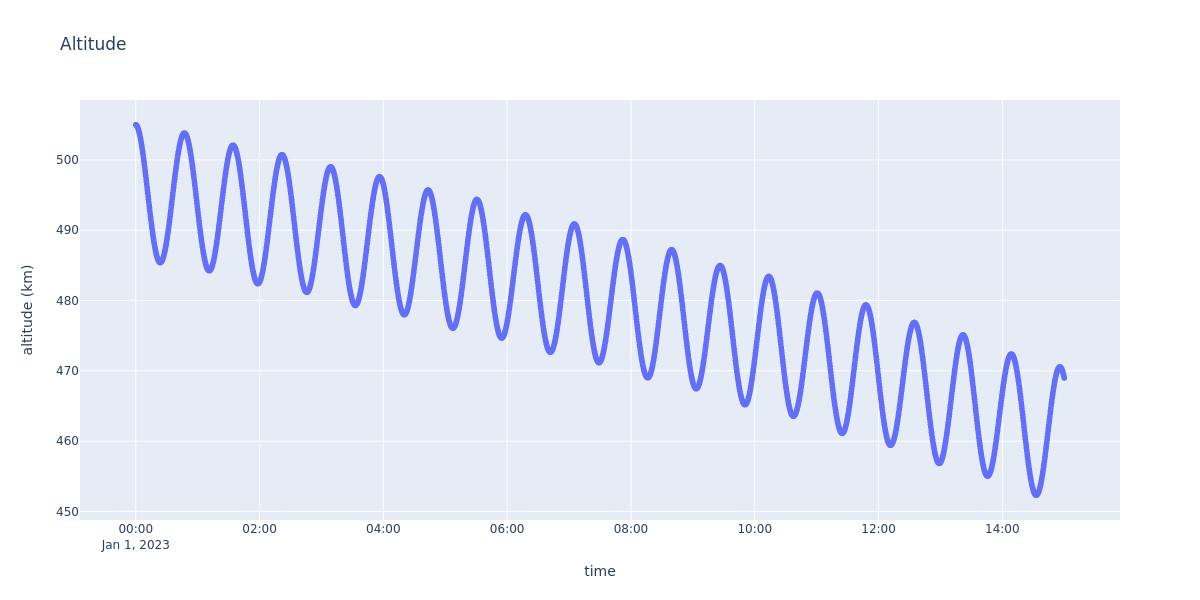

In [13]:
df = pd.DataFrame(data)
figure = px.scatter(
    data, x="time", y="altitude (km)", title="Altitude", height=600, width=1200
)
figure.show("png")

---